In [1]:
from pathlib import Path
import numpy as np
from crawfish.utils.testing import EXAMPLE_CALC_DIRS_DIR
from crawfish.core.operations.vector import get_gauss_smear_spectrum, get_lti_spectrum,get_uneven_integrated_array
from crawfish.core.elecdata import ElecData, los_projs_for_bands
from crawfish.funcs.general import SIGMA_DEFAULT, RES_DEFAULT
from crawfish.utils.typing import REAL_DTYPE, cs_formatter, COMPLEX_DTYPE
import matplotlib.pyplot as plt

def get_best_bands(unnorm_proj_tju):
    nstates = np.shape(unnorm_proj_tju)[0]
    nbands = np.shape(unnorm_proj_tju)[1]
    nproj = np.shape(unnorm_proj_tju)[2]
    band_proj_sums = np.zeros(nbands)
    for j in range(nbands):
        band_proj_sums[j] = np.sum(np.abs(unnorm_proj_tju[:,j,:]), axis=(0,1))
    idcs = np.argsort(band_proj_sums)[::-1]
    idcs_select = idcs[:nproj]
    idcs_sort = np.argsort(idcs_select)
    idcs_return = [idcs_select[i] for i in idcs_sort]
    return idcs_return

from numba import jit

def normalize_proj_tju(proj_tju: np.ndarray[COMPLEX_DTYPE], nloops=1000, conv=0.01):
    proj_tju_norm = proj_tju.copy()
    nproj: np.int64 = np.shape(proj_tju)[2]
    nstates: np.int64 = np.shape(proj_tju)[0]
    nbands: np.int64 = np.shape(proj_tju)[1]
    losses = np.zeros([nstates, nloops], dtype=REAL_DTYPE)
    proj_tju_norm = proj_tju.copy()
    return _normalize_proj_tju(proj_tju_norm, nloops, conv, losses, nstates, nproj, nbands)

@jit(nopython=True)
def _normalize_proj_tju(proj_tju_norm: np.ndarray[COMPLEX_DTYPE], nloops: int, conv: REAL_DTYPE, losses:np.ndarray[REAL_DTYPE],
                        nstates: int, nproj: int, nbands) -> tuple[np.ndarray[COMPLEX_DTYPE], np.ndarray[REAL_DTYPE]]:
    for t in range(nstates):
        for i in range(nloops):
            for j in range(nbands):
                asum: REAL_DTYPE = 0
                for u in range(nproj):
                    asum += np.real(np.conj(proj_tju_norm[t,j,u])*proj_tju_norm[t,j,u])
                proj_tju_norm[t,j,:] *= 1/(asum**0.5)
                losses[t,i] += np.abs(1-asum)
            for u in range(nproj):
                asum: REAL_DTYPE = 0
                for j in range(nbands):
                    asum += np.real(np.conj(proj_tju_norm[t,j,u])*proj_tju_norm[t,j,u])
                proj_tju_norm[t,:,u] *= 1/(asum**0.5)
                losses[t,i] += np.abs(1-asum)
            if losses[t,i] < conv:
                break
    return proj_tju_norm, losses

def los_projs_for_orbs(proj_tju: np.ndarray[COMPLEX_DTYPE]) -> np.ndarray[COMPLEX_DTYPE]:
    low_proj_tju = np.zeros_like(proj_tju)
    nstates = np.shape(proj_tju)[0]
    for t in range(nstates):
        s_uu = np.tensordot(proj_tju[t].conj().T, proj_tju[t], axes=([1], [0]))
        eigs, low_u = np.linalg.eigh(s_uu)
        nsqrt_ss_uu = np.eye(len(eigs)) * (eigs ** (-0.5))
        low_s_uu = np.dot(low_u, np.dot(nsqrt_ss_uu, low_u.T.conj()))
        low_proj_tju[t,:,:] += np.tensordot(proj_tju[t], low_s_uu, axes=([1], [0]))
    return low_proj_tju
def los_projs_for_bands(proj_sabcju: np.ndarray[COMPLEX_DTYPE]) -> np.ndarray[COMPLEX_DTYPE]:
    """Perform LOS on projections for band orthogonality.

    Perform Lowdin symmetric orthogonalization on projections for band orthogonality.

    Parameters
    ----------
    proj_sabcju : np.ndarray[COMPLEX_DTYPE]
        Projections in shape (nstates, nbands, nproj).
    """
    low_proj_tju = np.zeros_like(proj_tju)
    nstates = np.shape(proj_tju)[0]
    for t in range(nstates):
        s_uu = np.tensordot(proj_tju[t].conj().T, proj_tju[t], axes=([0], [1]))
        eigs, low_u = np.linalg.eigh(s_uu)
        nsqrt_ss_uu = np.eye(len(eigs)) * (eigs ** (-0.5))
        low_s_uu = np.dot(low_u, np.dot(nsqrt_ss_uu, low_u.T.conj()))
        low_proj_tju[t,:,:] += np.tensordot(proj_tju[t], low_s_uu, axes=([0], [1]))
    return low_proj_tju

n2_calcdir = EXAMPLE_CALC_DIRS_DIR / "N2_bare_min"
edata = ElecData(n2_calcdir)
# edata.norm_projs_t1()
nproj = edata.nproj
nspin = edata.nspin
nbands = edata.nbands
nstates = edata.nstates
kfolding = edata.kfolding
nk = np.prod(kfolding)
bestj = get_best_bands(edata.proj_tju)
trim = True
backfill = False
occ_sabcj = edata.occ_sabcj.copy()
e_sabcj = edata.e_sabcj.copy()
proj_sabcju = edata.proj_sabcju.copy()
proj_tju = edata.proj_tju.copy()
wk_sabc = edata.wk_sabc.copy()
if trim:
    nbands = edata.nproj
    proj_sabcju = edata.proj_sabcju.copy()[:,:,:,:,bestj,:]
    proj_tju = edata.proj_tju.copy()[:,bestj,:]
    e_sabcj = edata.e_sabcj.copy()[:,:,:,:,bestj]
    occ_sabcj = edata.occ_sabcj.copy()[:,:,:,:,bestj]
    if backfill:
        for j in range(nbands):
            if not j in bestj:
                e_sabcj[:,:,:,:,-1] += e_sabcj[:,:,:,:,j]
                occ_sabcj[:,:,:,:,-1] += occ_sabcj[:,:,:,:,j]
                proj_sabcju[:,:,:,:,-1,:] += proj_sabcju[:,:,:,:,j,:]
s,a,b,c,j = occ_sabcj.shape
t = s*a*b*c
occ_tj = occ_sabcj.reshape(t,j)
e_tj = e_sabcj.reshape(t,j)
wk_t = wk_sabc.flatten()
wk_jsabc = np.array([wk_sabc for _ in range(nbands)], dtype=REAL_DTYPE)
wk_sabcj = np.moveaxis(wk_jsabc, 0, -1)
nproj_tju, _ = normalize_proj_tju(proj_tju, nloops=100000)

ouproj_tju = los_projs_for_orbs(nproj_tju)

In [2]:
def get_proj_tju_for_s_uv_t(proj_tju, wk_t):
    proj_tju_for_s_uv_t = normalize_proj_tju_for_s_uv_t(proj_tju.copy(), wk_t)
    check_proj_tju_for_s_uv_t(proj_tju_for_s_uv_t, wk_t)
    return proj_tju_for_s_uv_t

def normalize_proj_tju_for_s_uv_t(proj_tju_for_s_uv_t, wk_t):
    for u in range(nproj):
        for t in range(nstates):
            asum = 0
            for j in range(nbands):
                asum += (proj_tju_for_s_uv_t[t, j, u].conj()*proj_tju_for_s_uv_t[t, j, u])
            proj_tju_for_s_uv_t[t,:,u] *= (1/asum)**0.5
    return proj_tju_for_s_uv_t

def check_proj_tju_for_s_uv_t(proj_tju_for_s_uv_t, wk_t):
    for u in range(nproj):
        for t in range(nstates):
            asum = 0
            for j in range(nbands):
                asum += (proj_tju_for_s_uv_t[t, j, u].conj()*proj_tju_for_s_uv_t[t, j, u])
            if not np.isclose(asum, 1):
                raise ValueError(f"u={u} is not normalized (S_uu={asum})")

def get_s_uv_t(proj_tju, wk_t):
    s_uv_t = np.zeros((nproj, nproj, nstates), dtype=COMPLEX_DTYPE)
    proj_tju_for_s_uv_t = get_proj_tju_for_s_uv_t(proj_tju, wk_t)
    for u in range(nproj):
        for v in range(nproj):
            for t in range(nstates):
                for j in range(nbands):
                    s_uv_t[u,v,t] += 1*(proj_tju_for_s_uv_t[t, j, u].conj()*proj_tju_for_s_uv_t[t, j, v])
    return s_uv_t

s_uv_t = get_s_uv_t(edata.proj_tju, wk_t)
s_uv = np.sum(s_uv_t, axis=2)
# s_uv += s_uv.conj()
# s_uv *= 0.5
s_uv = abs(s_uv)
proj_tju_for_s_uv_t = get_proj_tju_for_s_uv_t(proj_tju, wk_t)

0.037037037
(0.03703704+0j)
0.037037037
(0.037037034+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.03703703+0j)
5.551115e-17
(5.551115e-17+0j)
5.551115e-17
(5.551116e-17+0j)
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.037037037
(0.037037037+0j)
0.037037037
(0.037037045+0j)
0.037037037
(0.037037034+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
5.551115e-17
(5.5511148e-17+0j)
5.551115e-17
(5.5511145e-17+0j)
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.03703704+0j)
5.551115e-17
(5.5511164e-17+0j)
5.551115e-17
(5.551116e-17+0j)
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.0
0j
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
0.037037037
(0.037037037+0j)
5.551115e-17
(5.551115e-17+0j)
5.551115e-17
(5.551116e-17+0j)
0.0


Text(0.05713508650660515, -7.578637450933456e-08, 'reg = -0.00')

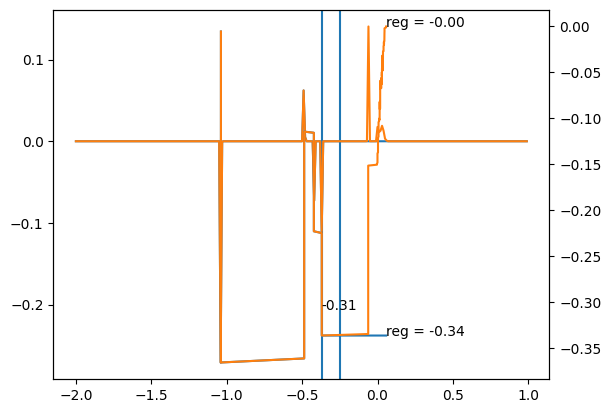

In [16]:
from crawfish.core.operations.scalar import gauss
from crawfish.core.operations.vector import get_uneven_integrated_array, get_gauss_smear_spectrum

ex_proj = ouproj_tju
p_t_uu = np.zeros([nbands, nproj, nproj], dtype=COMPLEX_DTYPE)
p_tj_uu = np.zeros([nstates, nbands, nproj, nproj], dtype=COMPLEX_DTYPE)
s2_tj_uu = np.zeros([nstates, nbands, nproj, nproj], dtype=COMPLEX_DTYPE)
s_tj_uu = np.zeros([nstates, nbands, nproj, nproj], dtype=COMPLEX_DTYPE)
t_tj_u = np.zeros([nstates, nbands, nproj, nproj], dtype=COMPLEX_DTYPE)
h_tj_uu = np.zeros([nstates, nbands, nproj, nproj], dtype=COMPLEX_DTYPE)
occ_j = np.zeros(nbands)

# for t in range(nstates):
#     for j in range(nbands):
#         for u in range(nproj):
#             for v in range(nproj):
#                 cw2 = np.conj(ex_proj[t,j,u])*ex_proj[t,j,v]
#                 s2_tj_uu[t,j,u,v] += 0.5*(cw2 + np.conj(cw2))

s2_tj_uu += 0.5 * (
    np.conj(ex_proj[:, :, :, np.newaxis]) * ex_proj[:, :, np.newaxis, :] + 
    np.conj(np.conj(ex_proj[:, :, :, np.newaxis]) * ex_proj[:, :, np.newaxis, :])
    )
#s2_tj_uu = np.einsum('tju,tju->tjuv', np.conj(ex_proj), ex_proj)
# s2_tj_uu = np.conj(ex_proj)[:,:]*ex_proj[:,:]


# for t in range(nstates):
#     for j in range(nbands):
#         uv_sum2 = np.sum(np.abs(s2_tj_uu[t,j,:,:]), axis=(0,1))
#         _p_tj_uu = (occ_tj[t,j]*wk_t[t]/uv_sum2)*abs(s2_tj_uu[t,j,:,:])
#         p_tj_uu[t,j,:,:]+=_p_tj_uu
p_tj_uu += (occ_tj[:, :, np.newaxis, np.newaxis] * wk_t[:, np.newaxis, np.newaxis, np.newaxis] / np.sum(np.abs(s2_tj_uu), axis=(2, 3), keepdims=True)) * np.abs(s2_tj_uu)

# for t in range(nstates):
#     for j in range(nbands):
#         tj_occ = occ_tj[t,j]*wk_t[t]
#         print(tj_occ)
#         tj_occ = np.sum(p_tj_uu[t,j,:,:,], axis=(0,1))
#         print(tj_occ)

h_tj_uu += p_tj_uu * e_tj[:, :, np.newaxis, np.newaxis]
# for t in range(nstates):
#     for j in range(nbands):
#         _h_tj_uu = p_tj_uu[t,j,:,:]*e_tj[t,j]
#         h_tj_uu[t,j,:,:]+=_h_tj_uu

# for t in range(nstates):
#     for j in range(nbands):
#         uv_sum2 = np.sum(np.abs(s2_tj_uu[t,j,:,:]), axis=(0,1))
#         _p_tj_uu = (occ_tj[t,j]*wk_t[t]/uv_sum2)*abs(s2_tj_uu[t,j,:,:])
#         p_tj_uu[t,j,:,:]+=_p_tj_uu
#         _h_tj_uu = _p_tj_uu*e_tj[t,j]
#         h_tj_uu[t,j,:,:]+=_h_tj_uu

for u in range(nproj):
    print(np.sum(s_uv[:,u], axis=(0)))

s_tj_uu *= nstates
fig, ax = plt.subplots(ncols=1, sharey=False)

p_uu = np.real(np.sum(p_tj_uu, axis=(0,1)))
h_uu = np.real(np.sum(h_tj_uu, axis=(0,1)))
s_uu = np.real(np.sum(s_tj_uu, axis=(0,1)))
t_u = np.real(np.sum(t_tj_u, axis=(0,1)))
# for u in range(nproj):
#     s_uu[u,:] *= 1/s_uu[u,u]
erange = np.arange(-2,1,0.01, REAL_DTYPE)
spectrum = np.zeros_like(erange)
weights_tj = np.zeros_like(e_tj)
ch1weights_tj = np.zeros_like(e_tj)
ch2weights_tj = np.zeros_like(e_tj)
weights_tj2 = np.zeros_like(e_tj)
weights_tj3 = np.zeros_like(e_tj)
weights_tj4 = np.zeros_like(e_tj)
weights_tj5 = np.zeros_like(e_tj)



for u in range(nproj):
    for v in range(nproj):
        pw = p_uu[u,v]
        hw = h_uu[u,v]
        sw = s_uv[u,v]
        if (u in [0,1,2,3]) and (v in [4,5,6,7]):
            for t in range(nstates):
                for j in range(nbands):
                    cw = np.conj(ex_proj[t,j,u])*ex_proj[t,j,v]
                    weights_tj[t,j] += hw*np.real(cw)*wk_t[t]*occ_tj[t,j]
                    weights_tj2[t,j] += hw*np.real(cw)*wk_t[t]
for u in range(nproj):
    for v in range(nproj):
        pw = p_uu[u,v]
        hw = h_uu[u,v]
        sw = s_uv[u,v]
        if (u in [0,1,2,3]) and (v in [4,5,6,7]):
            for t in range(nstates):
                for j in range(nbands):
                    cw = np.conj(ex_proj[t,j,u])*ex_proj[t,j,v]
                    weights_tj3[t,j] += sw*np.real(cw)*wk_t[t]*occ_tj[t,j]
                    weights_tj4[t,j] += sw*np.real(cw)*wk_t[t]

twinx = ax.twinx()

weights_sabcj = (weights_tj).reshape(s,a,b,c,nbands)
_spectrum = get_gauss_smear_spectrum(erange, e_sabcj, weights_sabcj, SIGMA_DEFAULT)
spectrum = _spectrum[0] + _spectrum[1]
ax.plot(erange, spectrum)
es, integs = get_uneven_integrated_array(e_sabcj, weights_sabcj)
twinx.plot(es, integs)
twinx.text(es[-1], integs[-1], f"reg = {integs[-1]:.2f}")


mu_idx = np.argsort(abs(np.array(es) - edata.mu))[0]
twinx.text(es[mu_idx], integs[mu_idx], f"{integs[mu_idx]:.2f}")
ax.axvline(x=edata.mu)
ax.axvline(x=es[mu_idx])

weights_sabcj = (weights_tj2).reshape(s,a,b,c,nbands)
_spectrum = get_gauss_smear_spectrum(erange, e_sabcj, weights_sabcj, SIGMA_DEFAULT)
spectrum = _spectrum[0] + _spectrum[1]
ax.plot(erange, spectrum)
es, integs = get_uneven_integrated_array(e_sabcj, weights_sabcj)
twinx.plot(es, integs)
twinx.text(es[-1], integs[-1], f"reg = {integs[-1]:.2f}")

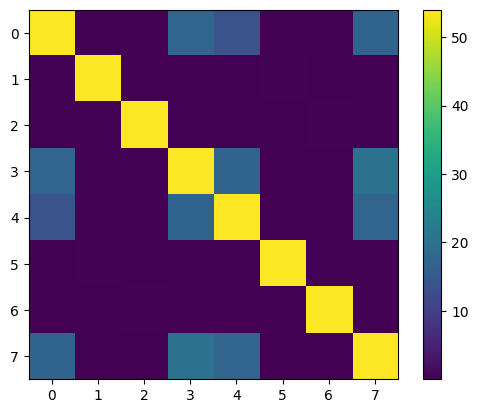

In [526]:
plt.imshow(s_uv)
plt.colorbar()

In [527]:
print(s_uv[1,5])

0.34370154
